# TalkingData AdTracking 데이터의 탐색적 분석 (Exploratory data analysis)
### 0. 데이터 필드 정보 및 의견
  - `ip`: ip address of click
  - `app`: app id for marketing
  - `device`: device type id of user mobile phone (e.g., iphone 6 plus, iphone 7, huawei mate 7, etc.)
  - `os`: os version id of user mobile phone
  - `channel`: channel id of mobile ad publisher
  - `click_time`: timestamp of click (UTC)
  - `attributed_time`: if user download the app for after clicking an ad, this is the time of the app download
    * 데이터 필드 중 유일하게 attributed_time 은 학습 데이터에만 존재하는데 다른 필드 데이터들로 하여금 테스트 데이터 내에 이 필드값의 예측치를 채워넣을 수 있을지 모르니  **반드시 확인하는 작업을 진행할 계획**입니다. 
  - `is_attributed`: the target that is to be predicted, indicating the app was downloaded

### 1. Upvote 1위의 EDA 자료를 요약 (by anokas)
- 자료 링크 - https://www.kaggle.com/anokas/talkingdata-adtracking-eda
  
- 예측 확률에 따라 평가되는 LogLoss 방식과는 달리 0, 1을 확실히 구분해내는 것이 중요한 AUROC 평가에 해당합니다.
    > 확률의 리스케일링 (상수 및 승수의 추가) 는 스코어에 영향이 없습니다.
  
- 압축된 1.8Gb 의 학습 데이터는 압축을 해제하면 무려 7.5Gb
    ```bash
    # File sizes
    train.csv                     7537.65MB
    test.csv                      863.27MB
    sample_submission.csv         195.58MB
    train_sample.csv              4.08MB

    # Line count:
    184903891 ../input/train.csv
    18790470 ../input/test.csv
    100001 ../input/train_sample.csv

    ```
    
- 저자는 백만개 라인만 입력으로 사용하였습니다.
- 데이터값이 전부 인코딩되어 있어서 다양한 차트를 통해 얻을 수 있는 인사이트가 **제한**됩니다.
- 그러므로, 저자는 각 필드의 인코딩값의 유니크수, 인코딩 값별 빈도수의 분포도, 빈도수별 ID수를 나타내는 히스토그램 세가지 차트를 확인하였습니다.
    * 약 4만 정도 index 근처 몇개 ip 들이 월등히 높은 6000 이상의 클릭수를 보이고 있습니다.
    * app 은 명확하진 않지만 index 180 근처에 조금은 집중된 모습입니다.
    * device 는 index 290 근처에 매우 높은 클릭수를 보인 1개 정도의 device 값이 있는 것이 확인됩니다.
    * os 도 index 160 근처에서 높은 클릭수를 보인 2개 정도의 os 값이 확인됩니다.
- 위 차트에서 확인한 것처럼 매우 극히 일부분의 필드값에 대해서만 Fraudulent 판정이 된 것으로 예상할 수 있습니다.
    * 백만개 라인 중 겨우 0.17% 가 Fraudulent 라고 판정된 데이터로 **결론적으로 매우 불균형적으로 학습될 수 있는 데이터이므로 over 또는 under 샘플링이 반드시 필요할 것으로 보입니다.**
    * **또는, 적절한 뉴럴넷의 하이퍼 파라미터 조정을 통해 이를 극복하거나 내부적으로 적절히 샘플링에 대응하는 Boolean 하이퍼 파라미터들을 포함하는 XGBoost, LightGBM 을 적용해보는 것이 좋은 방향 같습니다.**

### 2. EDA 체험

In [35]:
%%html
<!-- 에디터 폰트를 조정합니다. -->
<style type='text/css'>
.CodeMirror{
    font-size: 16px;
    font-family: D2Coding;
</style>

In [15]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import os
print(os.listdir("./data"))

['train_sample.csv.zip', 'sample_submission.csv.zip', 'test.csv', 'mnt', 'train.csv.zip', 'train.csv', 'test.csv.zip', 'talkingdata-adtracking-jongmin.ipynb']


In [16]:
# make wider graphs
sns.set(rc={'figure.figsize':(12,8)});
plt.figure(figsize=(12,8));

<Figure size 864x576 with 0 Axes>

In [70]:
# import all rows of train and all test data
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

In [71]:
train.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,83230,3,1,13,379,2017-11-06 14:32:21,NaN,0
1,17357,3,1,19,379,2017-11-06 14:33:34,NaN,0
2,35810,3,1,13,379,2017-11-06 14:34:12,NaN,0
3,45745,14,1,13,478,2017-11-06 14:34:52,NaN,0
4,161007,3,1,13,379,2017-11-06 14:35:08,NaN,0


In [72]:
test.head()

,click_id,ip,app,device,os,channel,click_time
0,0,5744,9,1,3,107,2017-11-10 04:00:00
1,1,119901,9,1,3,466,2017-11-10 04:00:00
2,2,72287,21,1,19,128,2017-11-10 04:00:00
3,3,78477,15,1,13,111,2017-11-10 04:00:00
4,4,123080,12,1,13,328,2017-11-10 04:00:00


describe 함수를 사용하여 category, datetime 측면의 정보를 얻기위해 type 을 설정합니다.

In [86]:
categorical_fields = ['ip', 'app', 'device', 'os', 'channel']
for field in categorical_fields:
    train[field] = train[field].astype('category')
    test[field]=test[field].astype('category')
train['is_attributed']=train['is_attributed'].astype('category')
    
# set click_time and attributed_time as timeseries
train['click_time'] = pd.to_datetime(train['click_time'])
train['attributed_time'] = pd.to_datetime(train['attributed_time'])
test['click_time'] = pd.to_datetime(test['click_time'])

top 는 most common value 를 의미합니다. 그리고 그 반복횟수가 freq 입니다.

In [87]:
train.describe()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
count,184903890.0,184903890.0,184903890.0,184903890.0,184903890.0,184903890,456846,184903890.0
unique,277396.0,706.0,3475.0,800.0,202.0,259620,182057,2.0
top,5348.0,3.0,1.0,19.0,280.0,2017-11-07 14:00:11,2017-11-08 14:16:29,0.0
freq,1238734.0,33911780.0,174330052.0,44181914.0,15065927.0,1502,14,184447044.0
first,NaN,NaN,NaN,NaN,NaN,2017-11-06 14:32:21,2017-11-06 16:00:47,NaN
last,NaN,NaN,NaN,NaN,NaN,2017-11-09 16:00:00,2017-11-09 16:00:00,NaN


필드별 유니크한 값 카운트입니다. ip 필드가 특별히 많은 유니크수를 보이고 있어서,
이들이 잘 분류(그룹)시킬 수 있다면 학습 데이터의 차원(Dimension)수를 줄여 모델 구축 속도를 개선함으로써 더 큰 볼륨의 학습 데이터를 가지고 모델을 만들어 볼 수 있을 것이라고 생각해보았습니다.

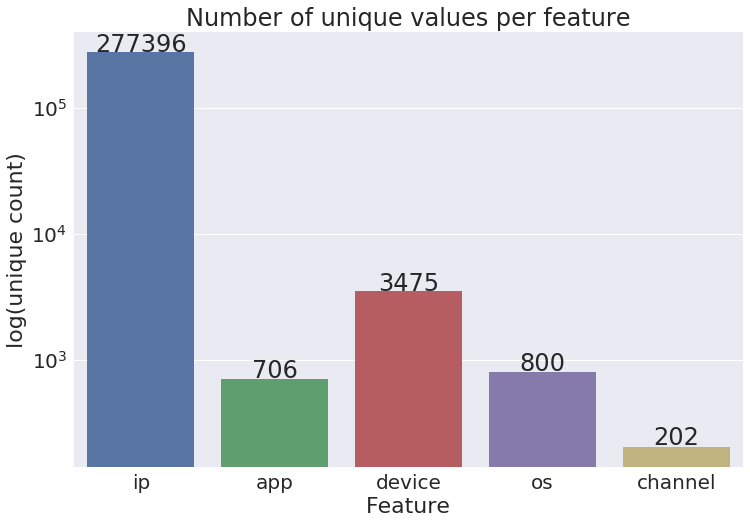

In [88]:
cols = ['ip', 'app', 'device', 'os', 'channel']
uniques = [len(train[col].unique()) for col in cols]

sns.set(font_scale=2)
pal = sns.color_palette()
ax = sns.barplot(cols, uniques, palette=pal, log=True)
ax.set(xlabel='Feature', ylabel='log(unique count)', title='Number of unique values per feature')

for p, uniq in zip(ax.patches, uniques):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 10,
            uniq,
            ha="center") 

Not Fradulent 클래스의 데이터가 대부분임에 주의해야합니다.

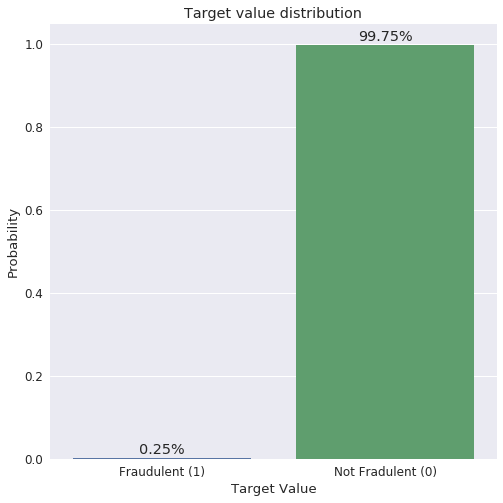

In [113]:
plt.figure(figsize=(8, 8))
sns.set(font_scale=1.2)
mean = (train.is_attributed.values == 1).mean()
ax = sns.barplot(['Fraudulent (1)', 'Not Fradulent (0)'], [mean, 1-mean], palette=pal)
ax.set(xlabel='Target Value', ylabel='Probability', title='Target value distribution')
for p, uniq in zip(ax.patches, [mean, 1-mean]):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height+0.01,
            '{}%'.format(round(uniq * 100, 2)),
            ha="center") 

Fraud 에 해당하는 데이터의 오버샘플링을 고려할때 ip 값의 range 에 따라 가중치를 둘수 있을 것 같습니다.

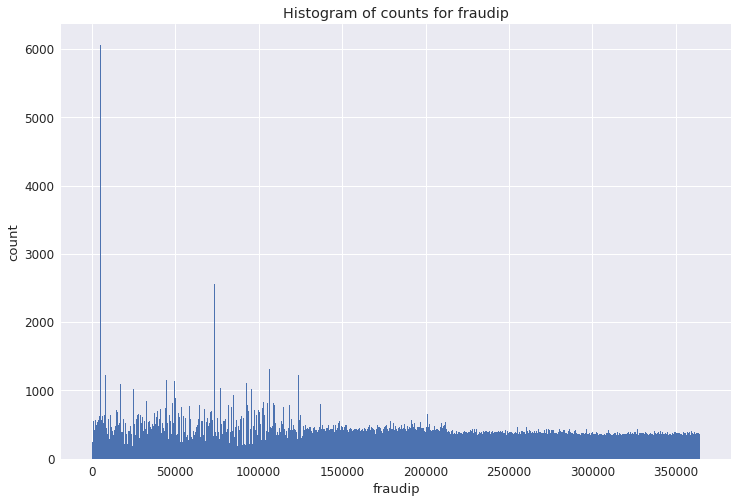

In [117]:
fraudip = train[["ip", "is_attributed"]][train["is_attributed"]==1]["ip"]

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
plt.hist(fraudip, bins=1000)
plt.title("Histogram of counts for {}".format('fraudip'))
plt.ylabel('count')
plt.xlabel('fraudip')
plt.show()

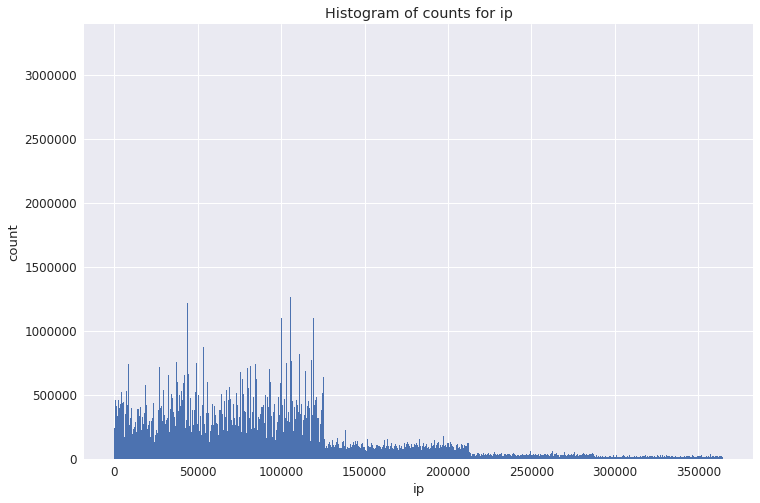

In [120]:
ip = train["ip"]

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
plt.hist(ip, bins=1000)
plt.title("Histogram of counts for {}".format('ip'))
plt.ylabel('count')
plt.xlabel('ip')
plt.show()

conversion time, app 이 동일한 경우의 카운트를 보면 0 부근의 값을 가진 앱들이 주로 단순한 반복성 어뷰징의 대상이 되는 것을 확인하였습니다.
 
(전체 트레이닝 데이터셋에서 is_attributed 에 따라 이러한 특징이 구분되는 것인지 확인해야합니다.)

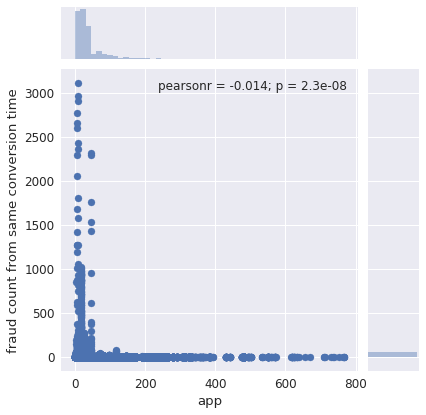

In [125]:
df_fraud = train[['app', 'click_time', 'attributed_time']].query('attributed_time != "NaT"')
df_fraud['conversion_time'] = df_fraud['attributed_time'] - df_fraud['click_time']

df_app_conversion_count = df_fraud[['app', 'click_time', 'attributed_time', 'conversion_time']].groupby(['app', 'conversion_time'], as_index=False)\
    .size()\
    .reset_index(name='count')\
    .sort_values('count', ascending=False)

ax = sns.jointplot(x='app', y='count', data=df_app_conversion_count)
ax.set_axis_labels(xlabel='app', ylabel='fraud count from same conversion time')

ip, device, os 모두를 조작하면서 어뷰징하는 fraud 가 얼마나 되는지 확인하기위해 ip, device, os 별 그룹 카운트 해보았습니다.

ip, device, os 그룹의 값이 전체 데이터셋에서 유일한 경우가 전체 fraud(또는 attributor)의 약 90% 를 차지합니다.

ip, device, os 그룹의 유니크수가 전체 데이터셋에서 1, 2 인 경우의 합은 전체의 약 96% 에 해당합니다. 

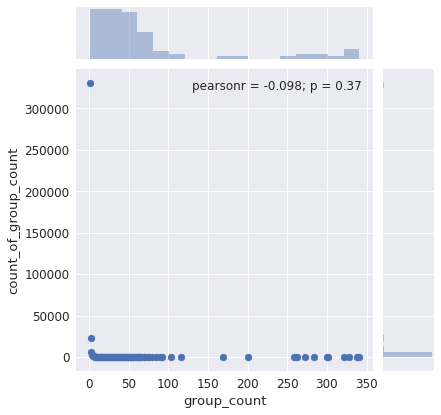

count_of_group_count    368695
dtype: int64


,group_count,count_of_group_count
0,1,330615


In [156]:
df_fraud = train[['ip', 'device', 'os', 'is_attributed']].query("is_attributed == 1")
df_fraud_unique_useragent = df_fraud.groupby(['ip', 'device', 'os'])\
    .size().reset_index(name='group_count')
df_fraud_count_of_unique_count = df_fraud_unique_useragent[['group_count']].groupby(['group_count'])\
    .size().reset_index(name='count_of_group_count')
    
sns.jointplot(x='group_count', y='count_of_group_count', data=df_fraud_count_of_unique_count)
plt.show()

print(df_fraud_count_of_unique_count.agg({'count_of_group_count' : 'sum'}))
df_fraud_count_of_unique_count.query("count_of_group_count > 300000")

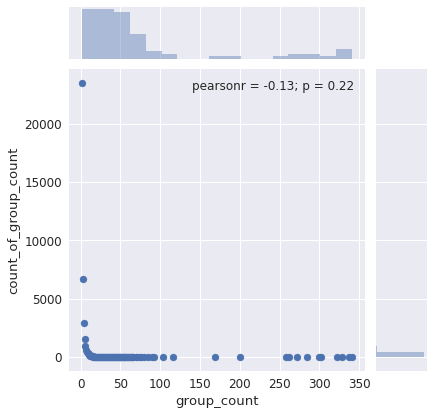

count_of_group_count    38080
dtype: int64


,group_count,count_of_group_count
1,2,23495


In [155]:
df_fraud = train[['ip', 'device', 'os', 'is_attributed']].query("is_attributed == 1")
df_fraud_unique_useragent = df_fraud.groupby(['ip', 'device', 'os'])\
    .size().reset_index(name='group_count')
df_fraud_count_of_unique_count = df_fraud_unique_useragent[['group_count']].groupby(['group_count'])\
    .size().reset_index(name='count_of_group_count').query("count_of_group_count < 300000")

sns.jointplot(x='group_count', y='count_of_group_count', data=df_fraud_count_of_unique_count)
plt.show()

print(df_fraud_count_of_unique_count.agg({'count_of_group_count' : 'sum'}))
df_fraud_count_of_unique_count.query("count_of_group_count > 20000")

ip, device, os 그룹 카운트를 전체 트레이닝 데이터셋에서 확인해봄과 동시에,

ip, device, os 의 조합별 특징을 살펴보았습니다. 

맨 오른쪽 열의 그래프들을 확인하면 역시 그룹 카운트 1인 경우에 attributor 가 집중되어있습니다.

그나마 히스토그램 상에서 고루 분포되어있는, 맨 왼쪽 열 ip 그래프를 확인해보면 os 값에서 특징이 보입니다.

os 값에서는 구분되는 3개의 직선이 보이고 이는 ip 만 바꿔가면서 특정 3개 os 에서 어뷰징을 시도한 것으로 보입니다. 더 나아가서는 ip 에 대한 1행의 그래프들 중 device, os 에 대한 그래프를 자세히 보면 특정 ip 대역폭으로 device, os 의 3개 값이 동일 높이로 보입니다. 즉, device 와 os 는 변경하지 않으면서 ip 만 특정 대역별로 조작하는 어뷰저로 판단하고, **테스트셋에서 이러한 어뷰저를 예측해낼때 유리한지 아니면, 여러 캐글유저의 의견처럼 단순히 attributor 를 예측해내는 것이 맞는 것인지** 모델의 성능을 보고 결정해야할 것 같습니다.

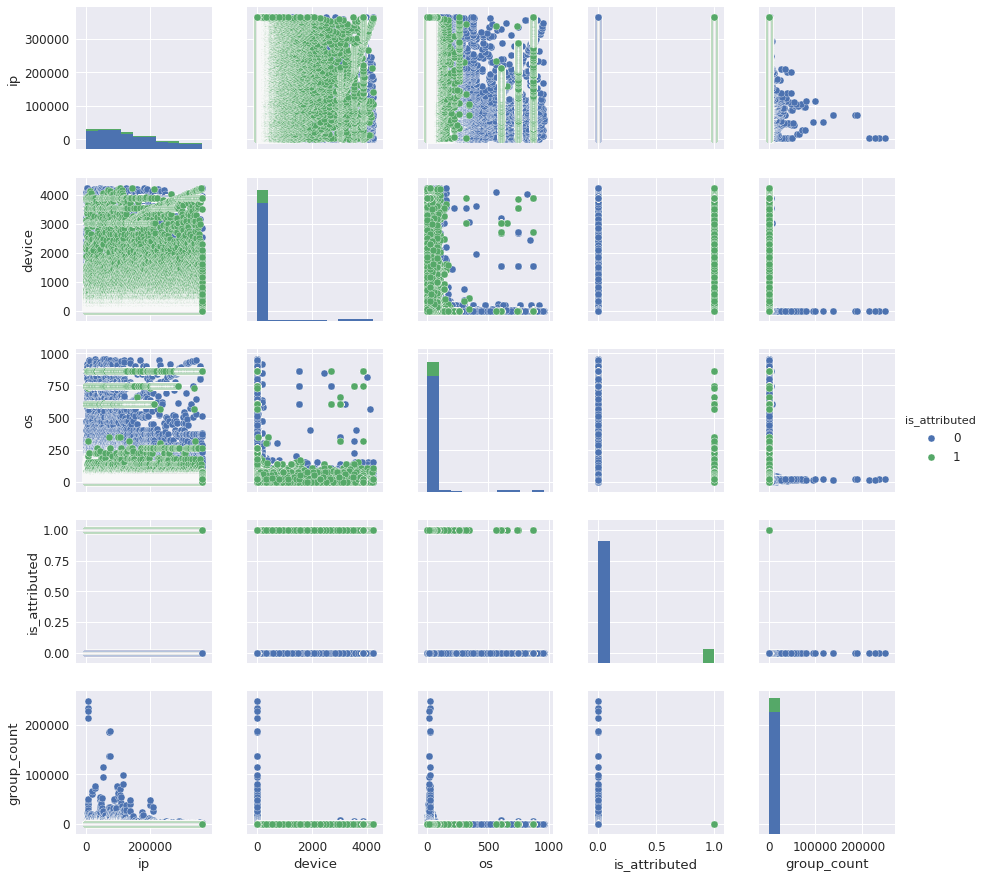

In [160]:
df_unique_useragent = train[['ip', 'device', 'os', 'is_attributed']].groupby(['ip', 'device', 'os', 'is_attributed'])\
    .size().reset_index(name='group_count')

sns.pairplot(hue='is_attributed',  data=df_unique_useragent)
plt.show()

#### 3/24 토요일 스터디 정리 내용
* 간단하게 피쳐 정리 및 파생 변수에 대한 이야기 진행
* 채널별 ip, os, device 의 중복개수 카운트
    - reinstall 카운트 피쳐
    - attribute time 이 없어서 못 씀
* 클릭 후 설치까지 30~40초
* 테스트셋에 ip 중복 있음. 케이스별로 예측하기 위해서 피쳐 그룹핑 등 작업 필요할 듯
* 동일 ip 에서도 시간에 따라 is_attributed 여부가 달라질 수 있음
* 클릭 후 재클릭 주기

###### 팀내 회의
* 파생 변수를 어떤 것을 추가하는냐가 핵심
* 다음주 공통적으로 생각해본 파생 변수를 몇개 골라보기
